# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Дерево решений


**Общая информация**

**Срок сдачи:** до 27 марта 2018, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 27 марта, -4 балла после 06:00 3 апреля, -6 баллов после 06:00 10 апреля

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw2.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. В комментариях, где написано "Что делает этот блок кода?", ответьте на этот вопрос. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на wine и Speed Dating Data.

###### Задание 2 (2 балла)
Добиться скорости работы на fit сравнимой со sklearn wine и Speed Dating Data. 
Для этого используем numpy. 

###### Задание 3 (2 балла)
Продемонстрируйте умение работать с Pipeline на данных Speed Dating Data и DecisionTreeClassifier. Нужно в pipeline произвести все необходимые преобразования данных и в конце обучить модель. Задание реализуйте под пунктом Задание 3 (уже написано ниже)

###### Задание 4 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 5 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%matplotlib inline
%load_ext pycodestyle_magic

In [109]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        l_w = l_s / (l_s + r_s)
        return l_w * (1 - ((l_c / l_s)**2).sum(axis=1, keepdims=True)) + (1 - l_w) * (1 - ((r_c / r_s)**2).sum(axis=1, keepdims=True))
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        p_l = l_c / l_s
        p_r = r_c / r_s
        h_l = -(p_l * np.nan_to_num(np.log2(p_l))).sum(axis=1, keepdims=True)
        h_r = -(p_r * np.nan_to_num(np.log2(p_r))).sum(axis=1, keepdims=True)
        l_w = l_s / (l_s + r_s)
        return l_w * h_l + (1 - l_w) * h_r

    def __misclass(self, l_c, l_s, r_c, r_s):
        l_w = l_s / (l_s + r_s)
        
        return l_w * (1 - np.max((l_c / l_s), axis=1, keepdims=True)) + (1 - l_w) * (1 - np.max((r_c / r_s), axis=1, keepdims=True))

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.sqrt(n_feature))]
        
    def __get_feature_ids_log2(self, n_feature):
        feature_ids = np.arange(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Что делает этот блок кода?
        # Сортируем элементы по x, для того, чтобы лучше находить разбиение по непрерывному признаку
        # class_number - количество уникальных классов
        sorted_x, sorted_y = self.__sort_samples(x, y)
        #class_number = np.unique(y).shape[0]
        class_number = self.num_class
        # Slack feature!
        cut_size = int(self.min_samples_split / 2) - 1
        # Что делает этот блок кода?
        # Вырезаем из y середину по минимальному количеству элементов разбиения(min_samples_split\cut_size)
        splitted_sorted_y = sorted_y[cut_size:-cut_size] if cut_size != 0 else sorted_y 
        # Получаем индексы, по которым происходит переход между классами, т.е находим индексы порогов 
        r_border_ids = np.where(splitted_sorted_y[:-1] != splitted_sorted_y[1:])[0] + (cut_size + 1)
        
        if len(r_border_ids) == 0:
            return float('+inf'), None
        
        # Что делает этот блок кода?
        # eq_el_count - расстояния между порогами
        eq_el_count = r_border_ids - np.append([cut_size], r_border_ids[:-1])
        # Кодируем категориальные переменные(например для класса 2 будет 0, 0, 1) для каждой левой части разбиений
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]), sorted_y[r_border_ids - 1]] = 1
        # Считаем количество классов в каждой левой части разбиений
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        # И добавляем оставшуюся, отрезанную крайнюю левую часть
        class_increments[0] = class_increments[0] + np.bincount(sorted_y[:cut_size], minlength=class_number)
        
        # Что делает этот блок кода?
        # Считаем сумму количеств классов для каждой левой части
        l_class_count = np.cumsum(class_increments, axis=0)
        # Сумма количеств классов для правой части. 
        # По сути вычитаем из суммы всех классов суммы количеств левой частей разбиений
        r_class_count = np.bincount(sorted_y, minlength=class_number) - l_class_count
        # Количество элементов левой и правой частей разбиений
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes

        # Что делает этот блок кода?
        # Вычисление неопределенности по заданному критерию для каждой из частей разбиений
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        # Ищем индекс наименьшую неопределенность
        idx = np.argmin(gs)
    
        # Что делает этот блок кода?
        # Получает индекс наилучшего разбиения
        left_el_id = l_sizes[idx][0]
        # Возвращает из функции значение наименьшей неопределенности и медиану разбиения к этой неопределенности
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0
    
    def __create_leaf(self, y):
        classes_count = np.bincount(y, minlength=self.num_class).astype('float')
        probs = classes_count / np.sum(classes_count)
        return (self.LEAF_TYPE, classes_count.argmax(), probs)
    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        # Ваш код
        # Необходимо использовать следующее:
        # self.LEAF_TYPE
        # self.NON_LEAF_TYPE
        
        # self.tree
        # self.max_depth
        # self.sufficient_share
        # self.min_samples_split

        # self.get_feature_ids
        # self.__find_threshold
        # self.__div_samples
        # self.__fit_node
        if y.size <= 20:
            print(y)
        if depth == self.max_depth or np.unique(y).size == 1 or y.size <= self.min_samples_split:
            print("Stopping criteria 1")
            self.tree[node_id] = self.__create_leaf(y)
            return
        feature_ids = self.get_feature_ids(x.shape[1])
        thresholds = np.empty(x.shape[1])
        gss = np.empty(x.shape[1])
        for feature_id in feature_ids:
            gss[feature_id], thresholds[feature_id] = self.__find_threshold(x[:, feature_id], y)
        best_feature_id = gss.argmin()
        best_threashold = thresholds[best_feature_id]
        print("BEST GS: ", gss.min())
        print("BEST threashold: ", best_threashold)
        print("BEST FEATURE_ID: ", best_feature_id)
        l_x, r_x, l_y, r_y = self.__div_samples(x, y, best_feature_id, best_threashold)
        logging.debug("l_y: %s", l_y)
        logging.debug("r_y: %s", r_y)
        if l_y.size == 0 or r_y.size == 0:
            print("Stopping criteria 2")
            self.tree[node_id] = self.__create_leaf(y)
            return
        
        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_id, best_threashold)
        # Left subtree
        self.__fit_node(l_x, l_y, node_id * 2 + 1, depth + 1)
        # Right subtree
        self.__fit_node(r_x, r_y, node_id * 2 + 2, depth + 1)
    
    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [110]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [111]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state=42, test_size=0.2, stratify=wine.target)

## Проверка скорости работы на wine

In [112]:
%time clf.fit(X_train, y_train)

CPU times: user 1.94 ms, sys: 1.03 ms, total: 2.97 ms
Wall time: 1.8 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [113]:
%time my_clf.fit(X_train, y_train)

DEBUG:root:l_y: [0 0 0 0 2 2 2 0 0 0 0 2 0 1 2 0 2 2 0 0 0 0 0 0 0 1 2 1 0 1 1 0 0 2 0 0 2
 1 2 0 0 0 0 0 0 2 2 0 0 2 2 0 2 0 2 2 2 0 0 1 0 0 0 2 1 2 0 0 2 0 0 2 2 2
 2 2 2 2 2 2 0 0 2 0 2 2 2 2 0 2 2]
DEBUG:root:r_y: [1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 1 1 1 1 0 1]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 1 1 1 1 1]
DEBUG:root:l_y: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
DEBUG:root

BEST GS:  0.3944997283853954
BEST threashold:  3.82
BEST FEATURE_ID:  9
BEST GS:  0.15455057762750063
BEST threashold:  1.58
BEST FEATURE_ID:  6
BEST GS:  0.03365384615384616
BEST threashold:  724.5
BEST FEATURE_ID:  12
Stopping criteria 1
[1 1 1 1 1 1 0 1]
BEST GS:  0.0
BEST threashold:  13.145
BEST FEATURE_ID:  0
[0]
Stopping criteria 1
[1 1 1 1 1 1 1]
Stopping criteria 1
BEST GS:  0.0
BEST threashold:  2.06
BEST FEATURE_ID:  2
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  0.03843137254901973
BEST threashold:  3.0
BEST FEATURE_ID:  2
[0]
Stopping criteria 1
BEST GS:  0.0
BEST threashold:  3.73
BEST FEATURE_ID:  11
[0]
Stopping criteria 1
Stopping criteria 1
CPU times: user 55.6 ms, sys: 24.1 ms, total: 79.8 ms
Wall time: 64.6 ms


## Проверка качества работы на wine

In [116]:
#f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')
print("Sklearn tree f1 on train: ", f1_score(y_pred=clf.predict(X_train), y_true=y_train, average='macro'))
print("Sklearn tree f1 on test: ", f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))

Sklearn tree f1 on train:  1.0
Sklearn tree f1 on test:  0.9457411645054666


In [117]:
print("My tree f1 on train: ", f1_score(y_pred=my_clf.predict(X_train), y_true=y_train, average='macro'))
print("My tree f1 on test: ", f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

My tree f1 on train:  1.0
My tree f1 on test:  0.9740129935032483


/Users/meudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 16384


{0: (0, 9, 3.82),
 1: (0, 6, 1.58),
 2: (0, 2, 3.0),
 3: (0, 12, 724.5),
 4: (0, 2, 2.06),
 5: (1, 0, array([1., 0., 0.])),
 6: (0, 11, 3.73),
 7: (1, 0, array([1., 0., 0.])),
 8: (0, 0, 13.145),
 9: (1, 2, array([0., 0., 1.])),
 10: (1, 1, array([0., 1., 0.])),
 13: (1, 0, array([1., 0., 0.])),
 14: (1, 1, array([0., 1., 0.])),
 17: (1, 0, array([1., 0., 0.])),
 18: (1, 1, array([0., 1., 0.]))}


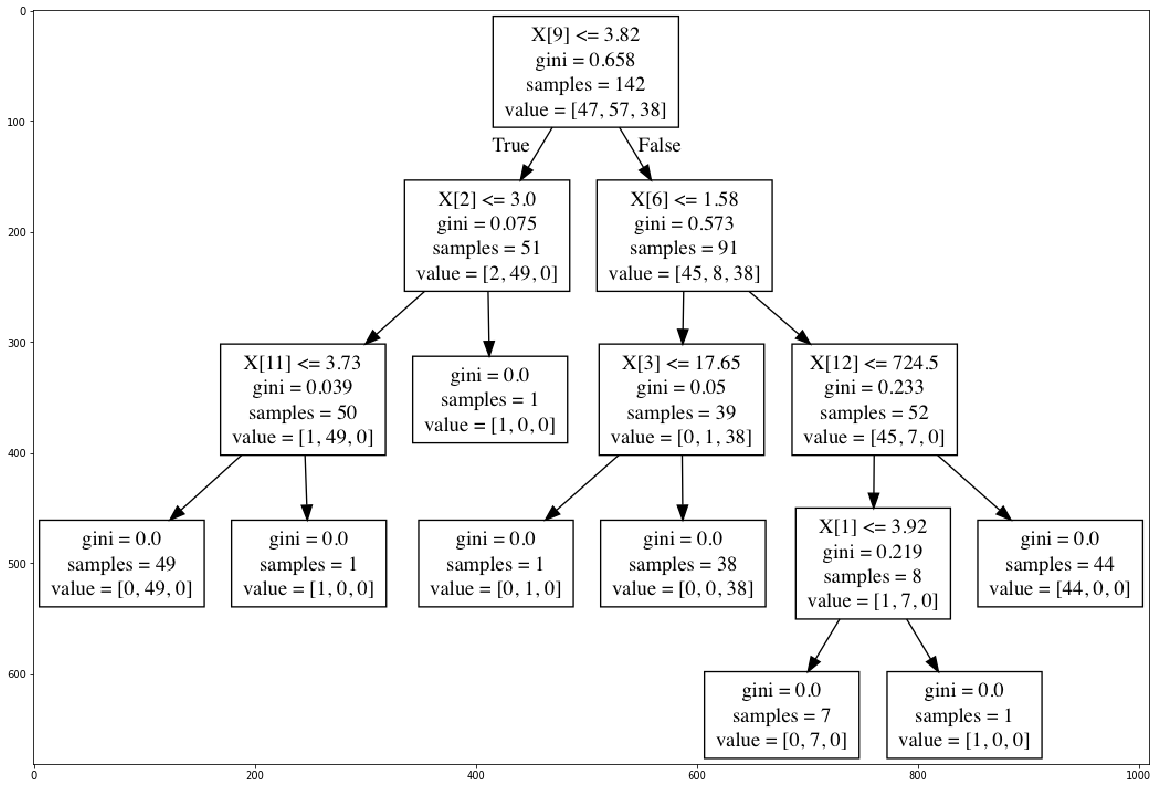

## Подготовка данных Speed Dating Data 

In [129]:
# тут делаете то же самое, что и на семинаре https://github.com/stroykova/spheremailru/blob/master/2018-02/lecture_04_trees/pract-speed-dating-trees-proc.ipynb
import pandas as pd
import numpy as np
!ls
df = pd.read_csv('speed-dating-experiment/sdd.csv', encoding='cp1251')
df = df.iloc[:, :97]
df.iid.nunique()

df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df.drop_duplicates(subset=['iid']).gender.value_counts()
df.drop_duplicates(subset=['iid']).condtn.value_counts()
df = df.drop(['condtn'], axis=1)

df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att',
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o'],
             axis=1)
df.drop_duplicates(subset=['iid']).age
df.drop_duplicates('iid').age.isnull().sum()
df = df.dropna(subset=['age'])

df.field_cd.isnull().sum()

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

df = df.drop(['field'], axis=1)
df = df.drop(['undergra'], axis=1)

df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

df.drop_duplicates('iid').mn_sat
df.drop_duplicates('iid').mn_sat.isnull().sum()
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)

df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').tuition
df.drop_duplicates('iid').tuition.isnull().sum()
df.loc[:, 'tuition'] = df.tuition.fillna(-999)

df.drop_duplicates('iid').race.value_counts()
df.drop_duplicates('iid').age.isnull().sum()
df.drop_duplicates('iid').race
df.drop_duplicates('iid').imprace.isnull().sum()
df.drop_duplicates('iid').imprelig.isnull().sum()

df = df.dropna(subset=['imprelig', 'imprace'])

df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

df.drop_duplicates('iid').loc[:, 'income']

df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

df = df.dropna(subset=['date'])

df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

df = df.drop(['career'], axis=1)
df.loc[:, ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
           'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
].isnull().sum()

df = df.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga'], axis=1)
df.drop_duplicates('iid').exphappy.isnull().sum()
df.drop_duplicates('iid').expnum.isnull().sum()
df = df.drop(['expnum'], axis=1)

feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx,]
idx = ((temp.wave >= 6) & (temp.wave <= 9))

temp.loc[idx,]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:,
                                                                                      'temp_totalsum'].T).T * 100
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx,]

idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx,]

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:,
                                                                                      'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]

    if i != 4:
        feat.remove('shar{}_1'.format(i))

    df = df.drop(feat, axis=1)

df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']) \
    .drop(['gender'], axis=1) \
    .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']) \
    .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1) \
    .dropna()
df_female.columns = df_female.columns + '_f'

df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)
df_pair.head()

X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=47)
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='entropy')
clf = DecisionTreeClassifier(min_samples_split=2, criterion='entropy')

hw2.ipynb               speed-dating-experiment tree.png
hw2_tests.ipynb         tree.dot


## Проверка скорости работы на Speed Dating Data 

In [130]:
%time clf.fit(X_train, y_train)

CPU times: user 85.2 ms, sys: 4.32 ms, total: 89.5 ms
Wall time: 85.9 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [131]:
%time my_clf.fit(X_train, y_train) 

/Users/meudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/Users/meudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
DEBUG:root:l_y: [0 0 0 ... 0 0 1]
DEBUG:root:r_y: [0 0 0 ... 0 1 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

BEST GS:  0.6288919235897164
BEST threashold:  4.0
BEST FEATURE_ID:  11
BEST GS:  0.5524006782030652
BEST threashold:  3.0
BEST FEATURE_ID:  6
BEST GS:  0.41907447970145184
BEST threashold:  0.13
BEST FEATURE_ID:  0
BEST GS:  0.5283675977706936
BEST threashold:  15.0
BEST FEATURE_ID:  23
BEST GS:  0.6616806692544511
BEST threashold:  1.0
BEST FEATURE_ID:  43
BEST GS:  0.6183771357123692
BEST threashold:  15162.0
BEST FEATURE_ID:  36
Stopping criteria 1
BEST GS:  0.7337408226740019
BEST threashold:  5.0
BEST FEATURE_ID:  42


DEBUG:root:l_y: [0 1 0 0 0 0 0 0 0 1 1 0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 0 1 1 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1]
DEBUG:root:l_y: [0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]
DEBUG:root:r_y: [1 1 0 1 1 1 1 1 1 1]
DEBUG:root:l_y: [0 1 1]
DEBUG:root:r_y: [0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 1 0 0 0 1 1 0]


BEST GS:  0.33870369574000064
BEST threashold:  20.0
BEST FEATURE_ID:  17
[0 1 0 0 0 0 0 0 0 1 1 0 1]
BEST GS:  0.36076584122252403
BEST threashold:  4.0
BEST FEATURE_ID:  37
Stopping criteria 2
BEST GS:  0.16182509907577805
BEST threashold:  20.0
BEST FEATURE_ID:  17
Stopping criteria 2
BEST GS:  0.7831113788044691
BEST threashold:  0.565
BEST FEATURE_ID:  0
[0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.7512099086606827
BEST threashold:  13.525000000000002
BEST FEATURE_ID:  57
[0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0]
BEST GS:  0.6259504933994419
BEST threashold:  9.0
BEST FEATURE_ID:  62
[0 1 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
[0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0]
BEST GS:  0.5
BEST threashold:  13.04
BEST FEATURE_ID:  26
[0 0 0 0 0 0 0]
Stopping criteria 1
[0 1 1 0 0 0 1 1 0]
BEST GS: 

DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0 0 0 1 0]
DEBUG:root:l_y: [0 0 0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [1 1 1 1]
DEBUG:root:r_y: [0 1 1 1 1 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 1 1 1 1 1]
DEBUG:root:l_y: [0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 1 0 1 0 1 0 1 1 1 1]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


 0.4333482810989027
BEST threashold:  17.275
BEST FEATURE_ID:  50
[1 1 1]
Stopping criteria 1
[0 0 0 0 1 0]
BEST GS:  -0.0
BEST threashold:  0.26
BEST FEATURE_ID:  0
[0 0 0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
[1 1 0 1 1 1 1 1 1 1]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  8
[1 1 1 1]
Stopping criteria 1
[0 1 1 1 1 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.5427025846116506
BEST threashold:  15.218478152184781
BEST FEATURE_ID:  22
BEST GS:  0.6384116268467748
BEST threashold:  -999.0
BEST FEATURE_ID:  40
BEST GS:  0.25217843393942263
BEST threashold:  19.09
BEST FEATURE_ID:  54
[1 1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  7.0
BEST FEATURE_ID:  11


DEBUG:root:l_y: [1 0 1 1 1 1 1 1]
DEBUG:root:r_y: [0 0 0 1]
DEBUG:root:l_y: [1 1 1 1 1 1 1]
DEBUG:root:r_y: [0]
DEBUG:root:l_y: [0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1]
DEBUG:root:l_y: [1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 1 0 1 0 0 0]
DEBUG:root:r_y: [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r

Stopping criteria 2
[1 0 1 0 1 0 1 0 1 1 1 1]
BEST GS:  0.37744375108173434
BEST threashold:  1.0
BEST FEATURE_ID:  10
[1 0 1 1 1 1 1 1]
BEST GS:  -0.0
BEST threashold:  0.16
BEST FEATURE_ID:  0
[1 1 1 1 1 1 1]
Stopping criteria 1
[0]
Stopping criteria 1
[0 0 0 1]
BEST GS:  -0.0
BEST threashold:  26.0
BEST FEATURE_ID:  2
[0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  6
Stopping criteria 2
BEST GS:  0.2529820580324991
BEST threashold:  1.0
BEST FEATURE_ID:  3
BEST GS:  0.1656683780030517
BEST threashold:  0.0
BEST FEATURE_ID:  1
BEST GS:  0.3691062096799267
BEST threashold:  6.0
BEST FEATURE_ID:  45
[0 0 0 1 0 1 0 0 0]
BEST GS:  0.3060986113514965
BEST threashold:  1.0
BEST FEATURE_ID:  38
[0 0 0 0]
Stopping criteria 1
[0 1 1 0 0]


DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1 1 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 1 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 1 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [0 0 1 0 0 1 0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0]


BEST GS:  -0.0
BEST threashold:  5.0
BEST FEATURE_ID:  3
[0 0]
Stopping criteria 1
[1 1 0]
BEST GS:  -0.0
BEST threashold:  0.33999999999999997
BEST FEATURE_ID:  0
[0]
Stopping criteria 1
[1 1]
Stopping criteria 1
BEST GS:  0.19419011889093374
BEST threashold:  15.0
BEST FEATURE_ID:  16
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 1 0 0 0 0]
BEST GS:  0.39355535745192405
BEST threashold:  1.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  -0.0
BEST threashold:  5.0
BEST FEATURE_ID:  18
Stopping criteria 1
[0 1 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  0.185
BEST FEATURE_ID:  0
[0 0 0 0 0 0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1]
BEST GS:  0.4772170014624825
BEST threashold:  4.0
BEST FEATURE_ID:  39
[0 0 1 0 0 1 0 1]

DEBUG:root:l_y: [1 0 1 1]
DEBUG:root:r_y: [0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 1 1]
DEBUG:root:l_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1 0 0 0 0


BEST GS:  0.4056390622295664
BEST threashold:  11494.5
BEST FEATURE_ID:  40
[1 0 1 1]
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  6
Stopping criteria 2
[0 0 0 0]
Stopping criteria 1
[0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.2373990014274907
BEST threashold:  20752.5
BEST FEATURE_ID:  36
BEST GS:  0.43028810682042024
BEST threashold:  1.0
BEST FEATURE_ID:  10
BEST GS:  0.4969528485774705
BEST threashold:  30.0
BEST FEATURE_ID:  21
[1]
Stopping criteria 1
BEST GS:  0.46895313872865746
BEST threashold:  4.0
BEST FEATURE_ID:  43
Stopping criteria 2


DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 0 0 0 0 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 0 0 0 0]
DEBUG:root:l_y: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

BEST GS:  0.14050799953410273
BEST threashold:  7.5
BEST FEATURE_ID:  59
Stopping criteria 1
[1 1 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
[0]
Stopping criteria 1
[1 1 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.0709002349024811
BEST threashold:  3.0
BEST FEATURE_ID:  10
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  50
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 1 0 0]
BEST GS:  -0.0
BEST threashold:  5.0
BEST FEATURE_ID:  3
Stopping criteria 2
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  17
Stopping criteria 1
[1 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  23.0
BEST FEATURE_ID:  2


DEBUG:root:r_y: [1 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0

Stopping criteria 2
BEST GS:  0.596649286717186
BEST threashold:  14.000000000000002
BEST FEATURE_ID:  51
BEST GS:  0.4685331698820383
BEST threashold:  16.0
BEST FEATURE_ID:  47
BEST GS:  0.3810611065576582
BEST threashold:  7.0
BEST FEATURE_ID:  61
BEST GS:  0.4086645181766464
BEST threashold:  1.0
BEST FEATURE_ID:  37


DEBUG:root:l_y: [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 1 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

BEST GS:  0.40384956171991127
BEST threashold:  1.0
BEST FEATURE_ID:  10
BEST GS:  0.4407582832544201
BEST threashold:  1.0
BEST FEATURE_ID:  6
BEST GS:  0.41118431229873736
BEST threashold:  20.0
BEST FEATURE_ID:  50
[1]
Stopping criteria 1
BEST GS:  0.39556672287172373
BEST threashold:  23.810000000000002
BEST FEATURE_ID:  17
BEST GS:  0.5084370572484765
BEST threashold:  4.0
BEST FEATURE_ID:  39
BEST GS:  0.5056794140971579
BEST threashold:  5.0
BEST FEATURE_ID:  11
[0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]


DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 0]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0 0 1 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 1 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 1 0 1 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0]
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


BEST GS:  -0.0
BEST threashold:  3.0
BEST FEATURE_ID:  42
[0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 1 0]
BEST GS:  -0.0
BEST threashold:  -0.055
BEST FEATURE_ID:  0
[1 1]
Stopping criteria 1
[0]
Stopping criteria 1
[1 0 0 1 1 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  39
[1 1]
Stopping criteria 1
[0 0 1 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  39
Stopping criteria 2
BEST GS:  0.25542951674962083
BEST threashold:  4.0
BEST FEATURE_ID:  39
Stopping criteria 2
BEST GS:  0.2806432954384885
BEST threashold:  8.0
BEST FEATURE_ID:  62
BEST GS:  0.356167361434502
BEST threashold:  2.0
BEST FEATURE_ID:  37
BEST GS:  0.1721804688852168
BEST threashold:  7.0
BEST FEATURE_ID:  44
[0 0 0]
Stopping criteria 1


DEBUG:root:l_y: [0 1 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 1 1 0]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0]
DEBUG:root:l_y: [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 0 0 0 1 1 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


BEST GS:  0.18999224152851504
BEST threashold:  27.0
BEST FEATURE_ID:  33
[0 1 0 0 0]
BEST GS:  -0.0
BEST threashold:  18.190041181900412
BEST FEATURE_ID:  17
[0 0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  10
Stopping criteria 2
[0 0 0 1 0 1 1 0 0 0 0 0 0 0]
BEST GS:  0.3467680694480959
BEST threashold:  13.421090323400092
BEST FEATURE_ID:  20
[0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[0 1 1 1 0]
BEST GS:  -0.0
BEST threashold:  15192.0
BEST FEATURE_ID:  9
[1 1 1]
Stopping criteria 1
[0 0]
Stopping criteria 1
BEST GS:  0.16929075444415753
BEST threashold:  16.28833333333333
BEST FEATURE_ID:  25
BEST GS:  0.31942919948083737
BEST threashold:  17.31
BEST FEATURE_ID:  48
BEST GS:  -0.0
BEST threashold:  9.0
BEST FEATURE_ID:  8
Stopping criteria 2
[1 0 0 0 0 0 1 1 0]


DEBUG:root:l_y: [1 0]
DEBUG:root:r_y: [0 0 0 0 1 1 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 1 1 0]
DEBUG:root:l_y: [0 1 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0]
DEBUG:root:l_y: [0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 

BEST GS:  0.3605680553151701
BEST threashold:  8.0
BEST FEATURE_ID:  3
[1 0]
Stopping criteria 1
[0 0 0 0 1 1 0]
BEST GS:  -0.0
BEST threashold:  8.0
BEST FEATURE_ID:  3
Stopping criteria 2
Stopping criteria 1
[0 0 0 1 1 0 0 0 0 0 0 1]
BEST GS:  0.27042604148637767
BEST threashold:  18.0
BEST FEATURE_ID:  18
[0 1 1]
BEST GS:  -0.0
BEST threashold:  -0.13
BEST FEATURE_ID:  0
[1 1]
Stopping criteria 1
[0]
Stopping criteria 1
[0 0 0 0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.2732858080612083
BEST threashold:  3.0
BEST FEATURE_ID:  43
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.2822665862295066
BEST threashold:  2.0
BEST FEATURE_ID:  41
[0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.29851765286782855
BEST threashold:  8.0
BEST FEATURE_ID:  3
BEST GS:  0.32507072970647005
BEST threashold:  9.0
BEST FEATURE_ID:  59
[1 0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  11
Stopping criteria 2

DEBUG:root:r_y: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 0]
DEBUG:root:l_y: [0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: [1 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 1]


[1 0 0]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
[0]
Stopping criteria 1
[1 0]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  42
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.1954452926522225
BEST threashold:  9.0
BEST FEATURE_ID:  62
[0 1]
Stopping criteria 1
BEST GS:  0.12032134914789372
BEST threashold:  7.0
BEST FEATURE_ID:  59
Stopping criteria 1
[0 0 1 0 0 0 0 0 0 0 1]
BEST GS:  0.2504443183784971
BEST threashold:  3.0
BEST FEATURE_ID:  8
[1 0]
Stopping criteria 1
[0 0 0 0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  1
Stopping criteria 2
[0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0]


DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [1 0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0]


BEST GS:  0.311787648548313
BEST threashold:  7.0
BEST FEATURE_ID:  13
[1]
Stopping criteria 1
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
BEST GS:  0.1721804688852168
BEST threashold:  7.0
BEST FEATURE_ID:  14
[0 1]
Stopping criteria 1
[0 0 0 0 0 0 0 0 0 0 0 1 0 0]
BEST GS:  -0.0
BEST threashold:  7.0
BEST FEATURE_ID:  13
Stopping criteria 2
BEST GS:  0.1553041266284561
BEST threashold:  14.707058588282344
BEST FEATURE_ID:  56
BEST GS:  0.13118511915064135
BEST threashold:  -999.0
BEST FEATURE_ID:  5
[0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 0 0 0 0 0 0 0 1 0 0]
BEST GS:  0.2119144232433437
BEST threashold:  23.61111111111111
BEST FEATURE_ID:  17
[1 0 1]


DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 1]
DEBUG:root:l_y: [0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 1 1 1 0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1 1 1 1]
DEBUG:root:l_y: [0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0]
DEBUG:root:r_y: [1 1 0 1 0 1 1 0 1 1 0 0 1 

BEST GS:  -0.0
BEST threashold:  -0.039999999999999994
BEST FEATURE_ID:  0
[1 1]
Stopping criteria 1
[0]
Stopping criteria 1
[0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.043728373050213785
BEST threashold:  9.76097609760976
BEST FEATURE_ID:  46
Stopping criteria 1
[0 0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.6257867343528619
BEST threashold:  2.0
BEST FEATURE_ID:  41
[0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0]
BEST GS:  0.3443609377704336
BEST threashold:  23.61111111111111
BEST FEATURE_ID:  17
[0 1 1 1 0 1]
BEST GS:  -0.0
BEST threashold:  3.5
BEST FEATURE_ID:  10
[0 0]
Stopping criteria 1
[1 1 1 1]
Stopping criteria 1
[0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.5899488983346186
BEST threashold:  -0.06
BEST FEATURE_ID:  0


DEBUG:root:l_y: [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 1 1 0 1 0 0 0 0]
DEBUG:root:r_y: [1 1 1 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 1 1]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 1 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 1 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 1 0]


BEST GS:  0.44701671287722544
BEST threashold:  10.0
BEST FEATURE_ID:  26
BEST GS:  0.43827755716237005
BEST threashold:  7.0
BEST FEATURE_ID:  27
[0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0]
BEST GS:  0.5754911750656064
BEST threashold:  2.0
BEST FEATURE_ID:  10
[0 0]
Stopping criteria 1
[0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0]
BEST GS:  0.6173137412725129
BEST threashold:  1.0
BEST FEATURE_ID:  10
[0 0 0 0 0 1 1 0 1 0 0 0 0]
BEST GS:  0.2496240382951178
BEST threashold:  7.5
BEST FEATURE_ID:  62
[0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[0 1 1 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
[1]
Stopping criteria 1
[0 1 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
[1 1 1 0]
BEST GS:  -0.0
BEST threashold:  30.0
BEST FEATURE_ID:  2
Stopping criteria 2


DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 1 1 0 0 0 0 0 0 0 0 0 1 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 0 0 0 0 1]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


BEST GS:  -0.0
BEST threashold:  14.0
BEST FEATURE_ID:  3
Stopping criteria 2
BEST GS:  0.2630719102181172
BEST threashold:  15.0
BEST FEATURE_ID:  46
[0 1 1 0 0 0 0 0 0 0 0 0 1 0]
BEST GS:  0.23179374984546652
BEST threashold:  6.0
BEST FEATURE_ID:  31
[0 0 0 0 0 0 0]
Stopping criteria 1
[1 1 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  7.5
BEST FEATURE_ID:  26
[1 1 1]
Stopping criteria 1
[0 0 0 0]
Stopping criteria 1
BEST GS:  0.18541348357083964
BEST threashold:  4.0
BEST FEATURE_ID:  37
[1]
Stopping criteria 1
BEST GS:  0.13655544138096234
BEST threashold:  26.0
BEST FEATURE_ID:  18
[1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  27.5
BEST FEATURE_ID:  23
[1]
Stopping criteria 1
Stopping criteria 1


DEBUG:root:l_y: [1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 1 1 1 1]
DEBUG:root:l_y: [1 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 1 1 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 1 0]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1
 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0
 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1

BEST GS:  0.5642905528520139
BEST threashold:  2.5
BEST FEATURE_ID:  38
[1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
BEST GS:  0.2840337403090643
BEST threashold:  8.0
BEST FEATURE_ID:  30
[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  3
[0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0]
BEST GS:  -0.0
BEST threashold:  -0.24
BEST FEATURE_ID:  0
[1]
Stopping criteria 1
[0 0]
Stopping criteria 1
[1 0 1 1 0]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  7
[0]
Stopping criteria 1
[1 1 1 0]
BEST GS:  -0.0
BEST threashold:  -0.21500000000000002
BEST FEATURE_ID:  0
[1 1 1]
Stopping criteria 1
[0]
Stopping criteria 1
[1 1 1 1 1 1]
Stopping criteria 1
BEST GS:  0.6731142862508834
BEST threashold:  14.000000000000002
BEST FEATURE_ID:  16


DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0

BEST GS:  0.5851033159015263
BEST threashold:  9.0
BEST FEATURE_ID:  62
BEST GS:  0.19385784083127314
BEST threashold:  2.0
BEST FEATURE_ID:  14
BEST GS:  0.08817744305868698
BEST threashold:  10.0
BEST FEATURE_ID:  28
Stopping criteria 2
[0 1 0 1 0 0]
BEST GS:  -0.0
BEST threashold:  2.0
BEST FEATURE_ID:  44
[0 0]
Stopping criteria 1
[1 0 1 0]
BEST GS:  -0.0
BEST threashold:  0.47
BEST FEATURE_ID:  0
[0 0]
Stopping criteria 1
[1 1]
Stopping criteria 1
BEST GS:  0.6349921526660629
BEST threashold:  7.0
BEST FEATURE_ID:  59
BEST GS:  0.6564110572678957
BEST threashold:  5.0
BEST FEATURE_ID:  45
BEST GS:  0.7194616669965695
BEST threashold:  29.0
BEST FEATURE_ID:  2


DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0
 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 1 1 0 1]
DEBUG:root:l_y: [1 0 0]
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 0 0]


BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
[0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[0 0 0 0 0 0 0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
BEST GS:  0.7842493569057338
BEST threashold:  20.0
BEST FEATURE_ID:  22
BEST GS:  0.1428571428571429
BEST threashold:  25.0
BEST FEATURE_ID:  48
[1 0 0]
BEST GS:  -0.0
BEST threashold:  0.6
BEST FEATURE_ID:  0
[1]
Stopping criteria 1
[0 0]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  22.0
BEST FEATURE_ID:  33
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 0 0]


DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1 0 0]
DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1]
DEBUG:root:r_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1
 0 0 1 0 0 1 0 1 0 1 1 1]
DEBUG:root:l_y: [0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 1 0 0 1 0 0]
DEBUG:root:r_y: [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 1 0 0]


BEST GS:  -0.0
BEST threashold:  24.0
BEST FEATURE_ID:  2
[0 0]
Stopping criteria 1
[1 0 0]
BEST GS:  -0.0
BEST threashold:  0.195
BEST FEATURE_ID:  0
[0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  0.8271876703395491
BEST threashold:  22.0
BEST FEATURE_ID:  2
BEST GS:  0.8516987853354037
BEST threashold:  2.0
BEST FEATURE_ID:  44
BEST GS:  0.6033336880570659
BEST threashold:  7.0
BEST FEATURE_ID:  31
BEST GS:  0.3635939058761771
BEST threashold:  15.0
BEST FEATURE_ID:  46
[0 1 0 0 1 0 0]
BEST GS:  -0.0
BEST threashold:  6.0
BEST FEATURE_ID:  39
[1]
Stopping criteria 1
[0 0 0 1 0 0]


DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r_y: [1 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1 0 0 0 0 0 1 1 1 0]
DEBUG:root:r_y: [0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1 0 1 1 1]
DEBUG:root:r_y: [0 0 0 0 0]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 1]
DEBUG:root:l_y: [0 1 1]
DEBUG:root:r_y: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0]


BEST GS:  -0.0
BEST threashold:  23.0
BEST FEATURE_ID:  2
[0 0 0 0]
Stopping criteria 1
[1 0]
Stopping criteria 1
[0 0 0 0 1 0 0 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  8.0
BEST FEATURE_ID:  14
Stopping criteria 2
BEST GS:  0.6218958316805951
BEST threashold:  20.0
BEST FEATURE_ID:  17
[1 0 0 0 0 0 1 1 1 0]
BEST GS:  0.36096404744368116
BEST threashold:  7.0
BEST FEATURE_ID:  34
[1 0 1 1 1]
BEST GS:  -0.0
BEST threashold:  -999.0
BEST FEATURE_ID:  9
[1 1 1]
Stopping criteria 1
[0 1]
Stopping criteria 1
[0 0 0 0 0]
Stopping criteria 1
[0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
BEST GS:  0.18048202372184058
BEST threashold:  7.0
BEST FEATURE_ID:  58
[0 1 1]
BEST GS:  -0.0
BEST threashold:  -0.04
BEST FEATURE_ID:  0
[1 1]

DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 0 1 1 1]
DEBUG:root:r_y: [1 1 1 1 1 0 1]
DEBUG:root:l_y: [0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1]
DEBUG:root:r_y: [0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0 1 1 1 1 0 1 0 1 1 1]
DEBUG:root:r_y: [0 0 0 0 0 1]
DEBUG:root:l_y: [1 1 1 1 1]
DEBUG:root:r_y: [0 0 1 0 1 0 1]
DEBUG:root:l_y: [1 1 0]
DEBUG:root:r_y: [0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 0]



Stopping criteria 1
[0]
Stopping criteria 1
[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  3.5
BEST FEATURE_ID:  42
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 1]
Stopping criteria 1
BEST GS:  0.8496139485564499
BEST threashold:  3.0
BEST FEATURE_ID:  34
BEST GS:  0.8394451479506091
BEST threashold:  8.0
BEST FEATURE_ID:  30
[0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1]
BEST GS:  0.6431328512696326
BEST threashold:  0.0
BEST FEATURE_ID:  1
[0 0 1 1 1 1 0 1 0 1 1 1]
BEST GS:  0.4591479170272448
BEST threashold:  19.23192319231923
BEST FEATURE_ID:  47
[1 1 1 1 1]
Stopping criteria 1
[0 0 1 0 1 0 1]
BEST GS:  0.46358749969093305
BEST threashold:  8.0
BEST FEATURE_ID:  3
[1 1 0]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  1
Stopping criteria 2
[0 0 0 1]


DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0]
DEBUG:root:l_y: [1]
DEBUG:root:r_y: [0 0 0 0 0]
DEBUG:root:l_y: [1 0 1 1 1 0 1 0 0]
DEBUG:root:r_y: [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0]
DEBUG:root:r_y: [1 1 1 1 1 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 1 1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 1 0 1 0]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0 0]


BEST GS:  -0.0
BEST threashold:  0.06
BEST FEATURE_ID:  0
[1]
Stopping criteria 1
[0 0 0]
Stopping criteria 1
[0 0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.635
BEST FEATURE_ID:  0
[1]
Stopping criteria 1
[0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.6229947699885229
BEST threashold:  8.0
BEST FEATURE_ID:  61
[1 0 1 1 1 0 1 0 0]
BEST GS:  -0.0
BEST threashold:  20.0
BEST FEATURE_ID:  24
[0 0 0]
Stopping criteria 1
[1 1 1 1 1 0]
BEST GS:  -0.0
BEST threashold:  28.5
BEST FEATURE_ID:  2
[0]
Stopping criteria 1
[1 1 1 1 1]
Stopping criteria 1
[0 0 0 1 1 0 0 1 0 0 0 0 0 0 0]
BEST GS:  0.21634083318910208
BEST threashold:  5.0
BEST FEATURE_ID:  3
[0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[0 1 1 0 1 0]
BEST GS:  -0.0
BEST threashold:  1.5
BEST FEATURE_ID:  43
[1 1 1]
Stopping criteria 1
[0 0 0]
Stopping criteria 1
[1 1 1 1 1 0 1]


DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 1 1 1 0 1]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 1]
DEBUG:root:r_y: [0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1]
DEBUG:root:l_y: [0 0 0 1 1]
DEBU

BEST GS:  -0.0
BEST threashold:  8.0
BEST FEATURE_ID:  7
Stopping criteria 2
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
BEST GS:  0.16205220600961584
BEST threashold:  8.0
BEST FEATURE_ID:  39
[0]
Stopping criteria 1
[0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0]
BEST GS:  -0.0
BEST threashold:  8.0
BEST FEATURE_ID:  39
Stopping criteria 2
BEST GS:  0.5123982976058539
BEST threashold:  12.0
BEST FEATURE_ID:  49
BEST GS:  0.32851900302612674
BEST threashold:  4.0
BEST FEATURE_ID:  7
Stopping criteria 1
BEST GS:  0.45536425041823025
BEST threashold:  13.0
BEST FEATURE_ID:  3
[0 0 0 1 1]
BEST GS:  -0.0
BEST threashold:  20.0
BEST FEATURE_ID:  15


DEBUG:root:r_y: [0 0 0 1 1]
DEBUG:root:l_y: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1]
DEBUG:root:r_y: [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]
DEBUG:root:l_y: [1 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1]
DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


Stopping criteria 2
BEST GS:  0.39515005881121296
BEST threashold:  10.0
BEST FEATURE_ID:  51
BEST GS:  0.1158968749227333
BEST threashold:  9.0
BEST FEATURE_ID:  60
Stopping criteria 2
BEST GS:  0.3192020300749048
BEST threashold:  7.0
BEST FEATURE_ID:  61
BEST GS:  0.09090909090909094
BEST threashold:  6.0
BEST FEATURE_ID:  38
[1 0 0]
BEST GS:  -0.0
BEST threashold:  -0.010000000000000009
BEST FEATURE_ID:  0
[0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  1
Stopping criteria 2
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]


DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 1 0 0 1 1]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0 0 0 1]
DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0]
DEBUG:root:r_y: [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
DEBUG:root:l_y: [1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0]
DEBUG:root:r_y: [1 0 0 0 0 0 1 0 0 0 0 1 0]
DEBUG:root:l_y: [0 0 0 1 1 0]
DEBUG:root:r_y: [1 1 1 1 1 1 0 1 1 1]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0 0 0 0]
DEBUG:root:l_y: []


BEST GS:  0.2743434150627885
BEST threashold:  2.0
BEST FEATURE_ID:  13
[0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 1 0 0 1 1]
BEST GS:  -0.0
BEST threashold:  15.0
BEST FEATURE_ID:  18
[1 1 1]
Stopping criteria 1
[0 0 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.05500000000000001
BEST FEATURE_ID:  0
[0 0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  0.7382739750875784
BEST threashold:  8.0
BEST FEATURE_ID:  59
BEST GS:  0.7813085130325976
BEST threashold:  26.0
BEST FEATURE_ID:  2
[1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0]
BEST GS:  0.4772170014624825
BEST threashold:  3.0
BEST FEATURE_ID:  39
[0 0 0 1 1 0]
BEST GS:  -0.0
BEST threashold:  1301.0
BEST FEATURE_ID:  4
[1 1]
Stopping criteria 1
[0 0 0 0]
Stopping criteria 1
[1 1 1 1 1 1 0 1 1 1]
BEST GS:  -0.0
BEST threashold:  55138.0
BEST FEATURE_ID:  9


DEBUG:root:r_y: [1 1 1 1 1 1 0 1 1 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 0 0 0 0 1 0 0 0 0 1 0]
DEBUG:root:l_y: [0 0 0]
DEBUG:root:r_y: [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
DEBUG:root:l_y: [0 1 0 0 1 1 1 1 0 0 0 0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0]
DEBUG:root:l_y: [1 1]
DEBUG:root:r_y: [0 0 0 1 1 1 0 0 0 0 1]
DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r_y: [0 1 1 1 0 0 1]
DEBUG:root:l_y: [1 1 1 1]
DEBUG:root:r_y: [0 0 0]


Stopping criteria 2
[1 0 0 0 0 0 1 0 0 0 0 1 0]
BEST GS:  0.37188206585666517
BEST threashold:  5.0
BEST FEATURE_ID:  45
Stopping criteria 2
BEST GS:  0.3470669101545328
BEST threashold:  3.0
BEST FEATURE_ID:  12
[0 0 0]
Stopping criteria 1
[0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
BEST GS:  0.255513314330176
BEST threashold:  3.0
BEST FEATURE_ID:  12
Stopping criteria 2
BEST GS:  0.3834569157267876
BEST threashold:  2.0
BEST FEATURE_ID:  43
Stopping criteria 1
BEST GS:  0.45209062074687
BEST threashold:  10.0
BEST FEATURE_ID:  26
[0 1 0 0 1 1 1 1 0 0 0 0 1]
BEST GS:  0.33450119581513627
BEST threashold:  8.0
BEST FEATURE_ID:  29
[1 1]
Stopping criteria 1
[0 0 0 1 1 1 0 0 0 0 1]
BEST GS:  0.32814913403971013
BEST threashold:  5.0
BEST FEATURE_ID:  53
[0 0 0 0]
Stopping criteria 1
[0 1 1 1 0 0 1]
BEST GS:  -0.0
BEST threashold:  0.125
BEST FEATURE_ID:  0
[1 1 1 1]
Stopping criteria 1
[0 0 0]
Stopping criteria 1


DEBUG:root:l_y: [0 1]
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 1 0 0 1 0 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 0 1]
DEBUG:root:l_y: [0 1 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0
 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1
 1 0 1 0 0 0

BEST GS:  0.23967389643622788
BEST threashold:  9.0
BEST FEATURE_ID:  38
[0 1]
Stopping criteria 1
BEST GS:  0.10810810810810811
BEST threashold:  5.0
BEST FEATURE_ID:  25
Stopping criteria 1
[0 0 0 1 0 0 1 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  20.0
BEST FEATURE_ID:  15
[0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 1]
BEST GS:  -0.0
BEST threashold:  26.0
BEST FEATURE_ID:  2
Stopping criteria 2
BEST GS:  0.8352991191431056
BEST threashold:  30.0
BEST FEATURE_ID:  17
[0 1 0 0 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  -0.46499999999999997
BEST FEATURE_ID:  0
[0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  0.8474974365543433
BEST threashold:  0.0
BEST FEATURE_ID:  56
BEST GS:  0.865387144840576
BEST threashold:  9.5
BEST FEATURE_ID:  62
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1


DEBUG:root:l_y: [1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0]
DEBUG:root:r_y: [1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1
 0 0 0 0 0]
DEBUG:root:l_y: [0 1 0 1 1 1 0 0]
DEBUG:root:r_y: [1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1
 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0]
DEBUG:root:l_y: [1 1 1 1 0]
DEBUG:root:r_y: [0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 1 1 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0 1
 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0]
DEBUG:root:l_y: [1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0]
DEBUG:root:r_y: [0 0 0 0 0 1 0 0 0 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0]


BEST GS:  0.9056467313670999
BEST threashold:  7.0
BEST FEATURE_ID:  60
BEST GS:  0.9015867445372515
BEST threashold:  9.0
BEST FEATURE_ID:  31
[0 1 0 1 1 1 0 0]
BEST GS:  0.4512050593046014
BEST threashold:  14647.5
BEST FEATURE_ID:  36
[1 1 1 1 0]
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  1
Stopping criteria 2
[0 0 0]
Stopping criteria 1
BEST GS:  0.831745371626948
BEST threashold:  9.0
BEST FEATURE_ID:  31
Stopping criteria 2
BEST GS:  0.6771987454242182
BEST threashold:  -999.0
BEST FEATURE_ID:  36
BEST GS:  0.5729690654475488
BEST threashold:  8.0
BEST FEATURE_ID:  58
Stopping criteria 2
[0 0 0 0 0 1 0 0 0 0 0 0 0]
BEST GS:  -0.0
BEST threashold:  0.0
BEST FEATURE_ID:  19


DEBUG:root:r_y: [1 0 0 0]
DEBUG:root:l_y: [0 0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 0 0 0 0 0 0 0 0 1]
DEBUG:root:l_y: [0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0
 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
DEBUG:root:r_y: [0 0 0 ... 0 1 0]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1
 1 0 1 

[0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 0]
BEST GS:  -0.0
BEST threashold:  0.015
BEST FEATURE_ID:  0
[0 0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  -0.0
BEST threashold:  1.0
BEST FEATURE_ID:  39
[0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 0 0 0 0 0 0 0 0 1]
BEST GS:  0.27548875021634683
BEST threashold:  2.0
BEST FEATURE_ID:  12
Stopping criteria 2
BEST GS:  0.7175129717850011
BEST threashold:  18.18181818181818
BEST FEATURE_ID:  50
BEST GS:  0.8521112079407985
BEST threashold:  7.5
BEST FEATURE_ID:  8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Stopping criteria 1
BEST GS:  0.8891496834252304
BEST threashold:  48929.0
BEST FEATURE_ID:  40


DEBUG:root:l_y: [1 1 1 0 1 0 1 1 1 1 1 1 1 1]
DEBUG:root:r_y: [0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0]
DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1 1 1 1 1 1 1 1 1 1 1 1]
DEBUG:root:l_y: [0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [1 1 1 1 1 1 1 1 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [1 1 1 1 1 1 1 1 0 0 0]
DEBUG:root:l_y: [0 1 1 1 0 1]
DEBUG:root:r_y: [0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1
 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [1 1 1]
DEBUG:root:r_y: [0 0 1]


BEST GS:  0.597517819872881
BEST threashold:  158.0
BEST FEATURE_ID:  32
[1 1 1 0 1 0 1 1 1 1 1 1 1 1]
BEST GS:  -0.0
BEST threashold:  21.592840715928407
BEST FEATURE_ID:  25
[0 0]
Stopping criteria 1
[1 1 1 1 1 1 1 1 1 1 1 1]
Stopping criteria 1
[0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0]
BEST GS:  0.48941370014983165
BEST threashold:  48542.5
BEST FEATURE_ID:  9
[0 0 0 0 0 0 0 0]
Stopping criteria 1
[1 1 1 1 1 1 1 1 0 0 0]
BEST GS:  -0.0
BEST threashold:  -999.0
BEST FEATURE_ID:  4
Stopping criteria 2
BEST GS:  0.8299966126279783
BEST threashold:  13.0
BEST FEATURE_ID:  3
[0 1 1 1 0 1]
BEST GS:  -0.0
BEST threashold:  8.0
BEST FEATURE_ID:  34
[1 1 1]
Stopping criteria 1
[0 0 1]
BEST GS: 

DEBUG:root:l_y: [0 0]
DEBUG:root:r_y: [1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1
 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0]
DEBUG:root:l_y: [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:r_y: [0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 

 -0.0
BEST threashold:  0.285
BEST FEATURE_ID:  0
[0 0]
Stopping criteria 1
[1]
Stopping criteria 1
BEST GS:  0.7991649855445208
BEST threashold:  4.0
BEST FEATURE_ID:  11
Stopping criteria 2
BEST GS:  0.6687465405256876
BEST threashold:  9.0
BEST FEATURE_ID:  62
BEST GS:  0.2924508424489308
BEST threashold:  15.0
BEST FEATURE_ID:  16
BEST GS:  0.10946979289269461
BEST threashold:  1.0
BEST FEATURE_ID:  38
Stopping criteria 1
[1 0 1 0 0 1 0 0]


DEBUG:root:l_y: [0 0 0 0]
DEBUG:root:r_y: [1 1 1 0]
DEBUG:root:l_y: [0]
DEBUG:root:r_y: [1 1 1]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DEBUG:root:l_y: []
DEBUG:root:r_y: [0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1
 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 1 0

BEST GS:  -0.0
BEST threashold:  2.0
BEST FEATURE_ID:  6
[0 0 0 0]
Stopping criteria 1
[1 1 1 0]
BEST GS:  -0.0
BEST threashold:  0.625
BEST FEATURE_ID:  0
[0]
Stopping criteria 1
[1 1 1]
Stopping criteria 1
BEST GS:  0.21518034448538598
BEST threashold:  15.0
BEST FEATURE_ID:  16
Stopping criteria 2
BEST GS:  0.7029064799503439
BEST threashold:  10.0
BEST FEATURE_ID:  14
Stopping criteria 2
CPU times: user 6.81 s, sys: 2.48 s, total: 9.3 s
Wall time: 7.5 s


## Проверка качества работы на Speed Dating Data

In [132]:
print(f1_score(y_pred=clf.predict(X_train), y_true=y_train, average='macro'))
print(f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))

1.0
0.5445703231446232


In [133]:
print(f1_score(y_pred=my_clf.predict(X_train), y_true=y_train, average='macro'))
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

0.7261812772156457
0.5014004780689534


## Задание 3

/Users/meudon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'sRGB' 41 1
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 54 16384


{0: (0, 11, 4.0),
 1: (0, 14, 1.0),
 2: (0, 50, 18.18181818181818),
 3: (0, 6, 2.0),
 4: (0, 0, -0.26),
 5: (0, 40, 48685.0),
 6: (1, 0, array([0.81818182, 0.18181818])),
 7: (0, 37, 1.0),
 8: (0, 16, 15.0),
 9: (1, 1, array([0., 1.])),
 10: (1, 0, array([1., 0.])),
 11: (0, 32, 158.0),
 12: (0, 34, 3.0),
 15: (1, 0, array([0.9137931, 0.0862069])),
 16: (1, 0, array([0.80851064, 0.19148936])),
 17: (1, 0, array([0.86123033, 0.13876967])),
 18: (0, 16, 14.000000000000002),
 23: (0, 25, 21.592840715928407),
 24: (1, 0, array([0.60869565, 0.39130435])),
 25: (0, 35, 1341.0),
 26: (1, 0, array([0.54545455, 0.45454545])),
 37: (1, 0, array([0.90502793, 0.09497207])),
 38: (0, 51, 15.0),
 47: (1, 0, array([1., 0.])),
 48: (0, 2, 31.0),
 51: (1, 1, array([0.42857143, 0.57142857])),
 52: (0, 0, 0.425),
 77: (0, 4, 1455.0),
 78: (0, 22, 10.0),
 97: (1, 0, array([1., 0.])),
 98: (1, 1, array([0., 1.])),
 105: (0, 33, 29.0),
 106: (0, 50, 18.36632673465307),
 155: (1, 1, array([0., 1.])),
 156: (

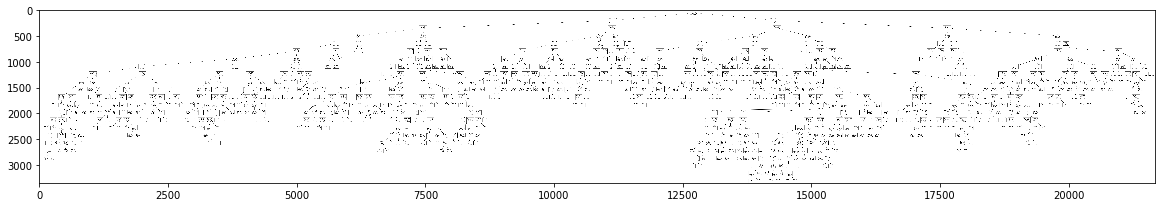

In [128]:
import io
from sklearn import tree
from scipy import misc
import subprocess
from pprint import pprint
dotfile = io.StringIO()
tree.export_graphviz(clf, out_file="tree.dot")
command = ["dot", "-Tpng", "tree.dot", "-o", "tree.png"]
subprocess.check_call(command)
pprint(my_clf.tree)
i = misc.imread("tree.png")
plt.figure(figsize = (20,20))
plt.imshow(i)

## Задание 4

## Задание 5